In [730]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import tsplib95,time,copy
random.seed(10) # Seed is set for all random number generations.

nearest_neighbor_routes_rate = 0.2    # The rate of routes that created with the nearest neighbors within the population.
population_size = 50                  # Number of individuals in the population.
mutation_probability = 0.1            # The rate of mutation applied to a route.
city_count = 100                      # Number of city.
mating_pool_individuals_count = 5     # Number of individuals in a single mating pool

In [731]:
# Each node is being represented with a Node class. 
class Node:
    def __init__(self, node_id, x, y):
        self.x = x
        self.y = y
        self.node_id = node_id
    
    # The distance function calculates EUC_2D distance between the existing node to a given node. EUC_2D is the
    # 2D Euclidean distance. Round operation is used to round the float number to the nearest integer.(It has same
    # functionality with NINT() in C.)
    def distance(self, node):
        xDis = abs(self.x - node.x)
        yDis = abs(self.y - node.y)
        distance = round(np.sqrt((xDis ** 2) + (yDis ** 2)))
        return distance
    
    def __repr__(self):
        #return "(" + str(self.x) + "," + str(self.y) + ")"
        return str(self.node_id)

In [732]:
# All nodes taken from the TSP dictionary is placed in a list. The type of the list is a Node list. All items are in the 
# Node class which represent Nodes in the tsp file.

def read_tsp(file_name,city_count):
    # With tsplib95 package the tsp file is assessed easly as dictionary.
    nodes = tsplib95.load(file_name)
    node_dict = nodes.node_coords

    nodeList = []

    for i in range(1,city_count+1):
        nodeList.append(Node(node_id = i, x=node_dict[i][0], y=node_dict[i][1]))
        
    return nodeList

In [733]:
# Initialization: 80% of the population is initialized randomly. For the remaining part, we 
# consider nearest-neighbor strategy, a very simple and intuitive way for initialization. In 
# this strategy, first a city x is selected randomly. Then, it selects the city that is closest to 
# city x and that has not been selected yet; now the new city becomes the base and this 
# step is repeated until all cities are selected. Note that it will prevent duplicates of 
# selecting the first city “x”.

def createRandomRoute(nodeList):
    # Route is created with selecting random nodes from the list.
    route = random.sample(nodeList, len(nodeList))
    return route

def createNearestNeighborRoute(nodeList):
    node_list_copy = copy.copy(nodeList)
    route = []
    # First select a random node from the list. And append it to the route.
    init_node = random.sample(node_list_copy,1)[0]
    route.append(init_node)
    node_list_copy.remove(init_node)
    # Find the nearest neigbor to the last appended node in the route. And append the nearest node to the route.
    # Iterate this until all nodes exhausted.
    while(len(node_list_copy) != 0):
        nearest_node = findNearestNeighbor(node_list_copy,route[-1])
        route.append(nearest_node)
        node_list_copy.remove(nearest_node)
    return route

def findNearestNeighbor(nodeList,init_node):
    # Find the nearest neighbour in the list to the selected init_node.
    min_distance = 10000000000
    nearest_node = None
    for i in range(len(nodeList)):
        calculated_dist = init_node.distance(nodeList[i])
        if calculated_dist < min_distance:
            min_distance = calculated_dist
            nearest_node = nodeList[i]
    return nearest_node

def initiatePopulation(nearest_neighbor_routes_rate,population_size,nodeList):
    # Poplution is initialized with random selected routes and with the routes created with nearest neighbor nodes.
    # The rate between these two types of routes is determined by nearest_neighbor_routes_rate parameter.
    population=[]
    
    # First initiate the individuals that is created with nearest neighbor nodes. A temporary list is used and 
    # all selected first nodes is saved in this list in order to memorize for further selections. If the newly
    # selected node exists in the temp list then the random selection process will repeat. 
    tmp_list = []
    for i in range(int(nearest_neighbor_routes_rate*population_size)):
        individual = createNearestNeighborRoute(nodeList)
        while (individual[0] in tmp_list) and (len(tmp_list) < len(individual)):
            individual = createNearestNeighborRoute(nodeList)
        tmp_list.append(individual[0])
        if len(tmp_list) == len(individual)+1:
            break
        population.append(individual)
        
    # Second initiate the individuals that is created with randomly selected nodes.
    for i in range(population_size - int(nearest_neighbor_routes_rate*population_size)):
        individual = createRandomRoute(nodeList)
        population.append(individual)
    
    return population


def calculateFitness(route):
    # Calculates total distance of the route. The distance between the last element and the first element is also added because
    # of the route is cyclic.
    route_distance = 0
    for i in range(len(route)):
        node = route[i]     
        # If the node is the last element then calculate the distance of the node and the first node.
        if route[i] == route[-1]:
            next_node = route[0]
        else:
            next_node = route[i+1]
        route_distance = route_distance + node.distance(next_node)
        #print("node: ",node," Next node: ",next_node," Distance: ",node.distance(next_node))
    return route_distance
        

def calculateBestFitness(population):
    #least_performing_individual_indice = None
    min_route_distance = 10000000
    for individual_indice in range(len(population)):
        route_distance = calculateFitness(population[individual_indice])
        if route_distance < min_route_distance:
            min_route_distance = route_distance
            #least_performing_individual_indice = individual_indice
    return min_route_distance

def calculateAverageFitness(population):
    total_route_distance = 0
    for individual_indice in range(len(population)):
        route_distance = calculateFitness(population[individual_indice])
        total_route_distance = total_route_distance + route_distance
    return total_route_distance/len(population)
    

In [734]:
# Crossover Operator: Two different crossover operators will be implemented:  
# Order Crossover (OX) and Sequential Constructive Crossover (SCX).

def orderedCrossover(parent1,parent2):
    # This function performs ordered crossover for given two parents. The output is a tuple of two children. 
    child1 =[None for i in range(len(parent1))]
    child2=[None for i in range(len(parent2))]
    
    # First and the second cut orders are selected randomly.
    orderA = int(random.random() * len(parent1))
    orderB = int(random.random() * len(parent1))
    start_order = min(orderA, orderB)
    end_order = max(orderA, orderB)
    
    # The nodes between the start_order and end_order of parent1 are copied to child1 in same order. Also perform this
    # operation with parent2 and child2.
    for i in range(start_order, end_order):
        child1[i] = parent1[i]
        child2[i] = parent2[i]

    # After copying the first parent1's cut part to Child1, the remainder None places of child1 is filled with parent2's
    # nodes. If the selected node of parent2 is already exist in child1 then order passes to next node of parent2. With
    # repeating this operation all None nodes of child1 is filled with parent2's nodes in same order.
    child1_indice = end_order
    parent2_indice = end_order
    while None in child1:
        if parent2[parent2_indice] not in child1:
            child1[child1_indice] = parent2[parent2_indice]
            child1_indice = child1_indice+1
            parent2_indice = parent2_indice+1
        else:
            parent2_indice = parent2_indice+1

        if parent2_indice == len(parent2):
            parent2_indice = 0
        if child1_indice == len(child1):
            child1_indice = 0
            
    # After copying the first parent2's cut part to Child2, the remainder None places of child2 is filled with parent1's
    # nodes. If the selected node of parent1 is already exist in child2 then order passes to next node of parent1. With
    # repeating this operation all None nodes of child1 is filled with parent1's nodes in same order.
    child2_indice = end_order
    parent1_indice = end_order
    while None in child2:
        if parent1[parent1_indice] not in child2:
            child2[child2_indice] = parent1[parent1_indice]
            child2_indice = child2_indice+1
            parent1_indice = parent1_indice+1
        else:
            parent1_indice = parent1_indice+1

        if parent1_indice == len(parent1):
            parent1_indice = 0
        if child2_indice == len(child2):
            child2_indice = 0        
            
    return (child1,child2)

def sequentialConstructiveCrossover(parent1,parent2):
    # This function performs Sequential Constructive Crossover operation with the given two parents. And produces
    # one child. 
    
    child = []
    
    # First, the first node of parent1 is taken to child as first node.
    child.append(parent1[0])
    child_indice = 0
    
    # Finds the next node of the last selected node of child in both parents. Then calculate the distences between the last
    # node of the child and the next nodes in both parents. Keep the nearest node as the next node in child. Iterate this
    # operation until the child is completed.
    
    while child_indice < len(parent1)-1:
        # Find the legitimate node for parent1 which comes after childs last node.
        for node_indice in range(len(parent1)):
            if parent1[node_indice] == child[child_indice]:
                parent1_candidate_indice = node_indice+1
                if parent1_candidate_indice == len(parent1):
                    parent1_candidate_indice = 0
                while parent1[parent1_candidate_indice] in child:
                    if parent1_candidate_indice != len(parent1)-1:
                        parent1_candidate_indice = parent1_candidate_indice+1
                    else:
                        parent1_candidate_indice = 0
                        
        # Find the legitimate node for parent2 which comes after childs last node.
        for node_indice in range(len(parent2)):
            if parent2[node_indice] == child[child_indice]:
                parent2_candidate_indice = node_indice+1
                if parent2_candidate_indice == len(parent2):
                    parent2_candidate_indice = 0
                while parent2[parent2_candidate_indice] in child:
                    if parent2_candidate_indice != len(parent2)-1:
                        parent2_candidate_indice = parent2_candidate_indice+1
                    else:
                        parent2_candidate_indice = 0

        # Calculate the distances between the last node of child and the legitimate nodes selected in both parent1 and parent2.
        dist1 = child[child_indice].distance(parent1[parent1_candidate_indice])
        dist2 = child[child_indice].distance(parent2[parent2_candidate_indice])
        
        # If distance between child last node and parent1's candidate is less than child's last node and parent2's candidate
        # then choose parent1's candidate.And choose parent2's candidate in reverse condition.
        if dist1 < dist2:
            child.append(parent1[parent1_candidate_indice])
        else:
            child.append(parent2[parent2_candidate_indice])
        child_indice = child_indice + 1
    
    
    return child


In [735]:
# There will be four types of mutation operators which are the insertion mutation (ISM), 
# the inversion mutation (IVM) and the swap mutation (SM), and the random mutation (RM).

def insertionMutation(route, mutation_probability):
    # The insertion mutation is applied based on insertion mutation probability with first if check. 
    new_route = copy.copy(route)
    if(random.random() < mutation_probability):
        # Both the node that is to be inserted and its place indice to be inserted is selected randomly(insertion_indice,
        # insert_node_indice).
        insertion_indice = int(random.random() * len(route))
        new_route = [None for i in range(len(route))]
        insert_node_indice = int(random.random() * len(route))
        new_route[insertion_indice] = route[insert_node_indice]
        new_route_indice=0
        # The insertion operation is performed based on the randomly selected values and the indexes shifted accordingly.
        while None in new_route:
            for route_indice in range(len(route)):
                if route[route_indice] not in new_route:
                    new_route[new_route_indice] = route[route_indice]
                    new_route_indice = new_route_indice + 1
                    if new_route_indice == len(route):
                        new_route_indice = 0
                    while (new_route[new_route_indice] != None) and (None in new_route):
                        new_route_indice = new_route_indice + 1
        return new_route
    return route
                    

def swapMutation(route, mutation_probability):
    # The swap mutation operator simply select two nodes randomly and swaps them in place.
    if(random.random() < mutation_probability):
        #new_route = [None for i in range(len(route))]
        new_route = copy.copy(route)
        first_node_indice = int(random.random() * len(route))
        second_node_indice = int(random.random() * len(route))
            
        node1 = route[first_node_indice]
        node2 = route[second_node_indice]

        new_route[first_node_indice] = node2
        new_route[second_node_indice] = node1

        return new_route
    return route

def inversionMutation(route, mutation_probability):
    # The inversion operator randomly selects two nodes and replace the all nodes in between two random nodes in inverse 
    # order. All remainder nodes stays as input order.
    if(random.random() < mutation_probability):
        first_node_indice = int(random.random() * len(route))
        second_node_indice = int(random.random() * len(route))
        new_route = [None for i in range(len(route))]
        if first_node_indice < second_node_indice:
            for (old_indice,new_indice) in zip(range(first_node_indice,second_node_indice),range(second_node_indice,first_node_indice, -1)):
                new_route[old_indice+1] = route[new_indice]
        else:
            for (new_indice,old_indice) in zip(range(second_node_indice,first_node_indice),range(first_node_indice,second_node_indice, -1)):
                new_route[new_indice+1] = route[old_indice]

        # After selected nodes and the nodes in between them are placed in newly created route, all remained nodes(which are
        # None) will be replaced with the existing nodes of inpute route in the same order.
        new_route_indice=0                
        while None in new_route:
            for route_indice in range(len(route)):
                if route[route_indice] not in new_route:
                    new_route[new_route_indice] = route[route_indice]
                    new_route_indice = new_route_indice + 1
                    if new_route_indice == len(route):
                        new_route_indice = 0
                    while (new_route[new_route_indice] != None) and (None in new_route):
                        new_route_indice = new_route_indice + 1
        return new_route
    return route

def randomMutation(route, mutation_probability):
    # Random mutation operator selects a random mutation operator among Inversion, Swap and Insertion Mutation.
    selection = int(random.random() * 3)
    if selection == 0:
        new_route = insertionMutation(route, mutation_probability)
    elif selection == 1:
        new_route = swapMutation(route, mutation_probability)
    else:
        new_route = inversionMutation(route, mutation_probability)
    return new_route
    

In [736]:
def parentSelection(population,mating_pool_individuals_count):
    # This function create a mating pool with 5 individuals selected randomly from the population.
    mating_pool = []
    for individual in range(mating_pool_individuals_count):
        mating_pool.append(int(random.random() * len(population)))
    
    # After the mating pool which includes parent indices taken randomly from population is created, the two parents that have
    # minimum total distance will be elected as mating parents.
    # Selection of first parent:
    minimum_distance = 1000000000
    elected_parent1 = None
    for route_indice in mating_pool:
        total_distance = calculateFitness(population[route_indice])
        if total_distance < minimum_distance:
            minimum_distance = total_distance
            elected_parent1 = route_indice
    mating_pool.remove(elected_parent1)
    # Selection of second parent:
    minimum_distance = 1000000000
    elected_parent2 = None
    for route_indice in mating_pool:
        total_distance = calculateFitness(population[route_indice])
        if total_distance < minimum_distance:
            minimum_distance = total_distance
            elected_parent2 = route_indice        
    
    return (population[elected_parent1],population[elected_parent2])

def survivorSelection(child,population):
    # Since the algorithm is a steady-state GA in each iteration, only a part of the population is replaced by the offsprings.
    # Child1 and child2 will be replaced with the least performing parents in the existing population if these childs are
    # better than the least performing individuals in the population.
    
    #Get least performing individual in the population.
    max_route_distance = 0
    least_performing_individual_indice = None
    for individual_indice in range(len(population)):
        route_distance = calculateFitness(population[individual_indice])
        if route_distance > max_route_distance:
            max_route_distance = route_distance
            least_performing_individual_indice = individual_indice
    
    # Replace the given child with the least performing individual in te population.
    new_population = copy.copy(population)
    new_population[least_performing_individual_indice] = child
    #print(least_performing_individual_indice)
    return new_population
    
    

In [737]:
# A final function to perform a single iteration based on given inputs.

def generate(population,crossover_operator,mutation_operator,generation_count):
    iterations = []
    best_solution = []
    average_solution = []
    for i in range(generation_count):
        parent1,parent2 = parentSelection(population,mating_pool_individuals_count)
        if crossover_operator == "OX":
            child1,child2 = orderedCrossover(parent1,parent2)
            if mutation_operator == "ISM":
                mutated_child1 = insertionMutation(child1, mutation_probability)
                mutated_child2 = insertionMutation(child2, mutation_probability)
                population = survivorSelection(mutated_child1,population)
                population = survivorSelection(mutated_child2,population)
            elif mutation_operator == "IVM":
                mutated_child1 = invertionMutation(child1, mutation_probability)
                mutated_child2 = invertionMutation(child2, mutation_probability)
                population = survivorSelection(mutated_child1,population)
                population = survivorSelection(mutated_child2,population)
            elif mutation_operator == "SM":
                mutated_child1 = swapMutation(child1, mutation_probability)
                mutated_child2 = swapMutation(child2, mutation_probability)
                population = survivorSelection(mutated_child1,population)
                population = survivorSelection(mutated_child2,population)
            elif mutation_operator == "RM":
                mutated_child1 = RandomMutation(child1, mutation_probability)
                mutated_child2 = RandomMutation(child2, mutation_probability)
                population = survivorSelection(mutated_child1,population)
                population = survivorSelection(mutated_child2,population)  
        else:
            child1 = sequentialConstructiveCrossover(parent1,parent2)
            if mutation_operator == "ISM":
                mutated_child1 = insertionMutation(child1, mutation_probability)
                population = survivorSelection(mutated_child1,population)
            elif mutation_operator == "IVM":
                mutated_child1 = invertionMutation(child1, mutation_probability)
                population = survivorSelection(mutated_child1,population)
            elif mutation_operator == "SM":
                mutated_child1 = swapMutation(child1, mutation_probability)
                population = survivorSelection(mutated_child1,population)
            elif mutation_operator == "RM":
                mutated_child1 = RandomMutation(child1, mutation_probability)
                population = survivorSelection(mutated_child1,population)

        best_rank = calculateBestFitness(population)
        average_rank = calculateAverageFitness(population)
        iterations.append(i)
        best_solution.append(best_rank)
        average_solution.append(average_rank)
        
    df = pd.DataFrame()
    df["iterations"] = iterations
    df["best_solution"] = best_solution
    df["average_solution"] = average_solution
    df = df.set_index("iterations")
    return df


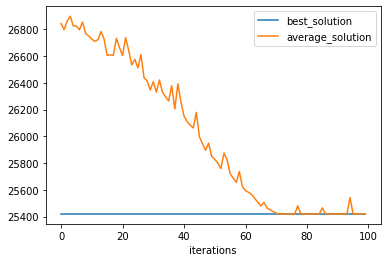

In [757]:
# Experiment 1: Varying the Crossover and Mutation Types

file_name = 'kroA100.tsp'             # Num of cities:100, Best ratig: 21282
nearest_neighbor_routes_rate = 1    # The rate of routes that created with the nearest neighbors within the population.
population_size = 50                  # Number of individuals in the population.
mutation_probability = 0.1            # The rate of mutation applied to a route.
city_count = 100                       # Number of city.
mating_pool_individuals_count = 5     # Number of individuals in a single mating pool
#crossover_operator                   # "OX" for Ordered Crossover Operator, "SCX" Sequential Constructive Crossover.
#mutation_operator                    # "ISM" Insertion Mutation, "IVM" Inversion Mutation, "SM" Swap Mutation, 
                                      # "RM" Random mutation
#generation_count                     # Number of iterations(generations)


random.seed(1)                        # Seed is set for all random number generations.   
 
node_list = read_tsp(file_name,city_count)
population = initiatePopulation(nearest_neighbor_routes_rate,population_size,node_list)    


df = generate(population=copy.copy(population),crossover_operator="OX",mutation_operator="ISM",generation_count=100)
df.plot()


In [758]:
df

,best_solution,average_solution
iterations,,
0,25420,26842.20
1,25420,26797.88
2,25420,26861.02
3,25420,26897.28
4,25420,26824.20
...,...,...
95,25420,25420.00
96,25420,25420.00
97,25420,25420.00


In [740]:
#random.seed(i) # Seed is set for all random number generations.   
population = initiatePopulation(nearest_neighbor_routes_rate,population_size,node_list)   
population

[[27,
  86,
  35,
  20,
  12,
  7,
  9,
  57,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  79,
  53,
  88,
  16,
  22,
  94,
  70,
  66,
  65,
  4,
  97,
  56,
  80,
  31,
  89,
  42,
  8,
  92,
  1,
  63,
  6,
  49,
  90,
  19,
  75,
  26,
  99,
  47,
  93,
  28,
  67,
  58],
 [100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  12,
  27,
  86,
  35,
  20,
  57,
  7,
  9,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  7

In [741]:
parent1,parent2 = parentSelection(population,mating_pool_individuals_count)
parent1

[65,
 66,
 4,
 97,
 56,
 80,
 31,
 89,
 42,
 8,
 92,
 1,
 63,
 6,
 49,
 90,
 10,
 84,
 72,
 21,
 74,
 59,
 17,
 15,
 11,
 32,
 91,
 98,
 23,
 45,
 47,
 93,
 28,
 67,
 58,
 61,
 25,
 81,
 69,
 73,
 50,
 44,
 2,
 54,
 40,
 64,
 68,
 85,
 39,
 30,
 96,
 78,
 52,
 5,
 37,
 33,
 76,
 13,
 95,
 82,
 48,
 100,
 71,
 41,
 14,
 3,
 46,
 29,
 34,
 83,
 55,
 12,
 27,
 86,
 35,
 20,
 57,
 7,
 9,
 87,
 51,
 77,
 60,
 62,
 43,
 75,
 19,
 53,
 79,
 18,
 24,
 38,
 36,
 99,
 94,
 22,
 16,
 88,
 70,
 26]

In [742]:
parent2

[14,
 43,
 36,
 81,
 19,
 34,
 85,
 6,
 13,
 22,
 94,
 5,
 1,
 42,
 44,
 93,
 21,
 54,
 57,
 80,
 3,
 56,
 71,
 73,
 52,
 16,
 51,
 8,
 4,
 18,
 31,
 65,
 63,
 50,
 41,
 17,
 37,
 40,
 9,
 64,
 61,
 55,
 62,
 98,
 10,
 49,
 79,
 38,
 75,
 47,
 92,
 2,
 100,
 32,
 82,
 30,
 24,
 70,
 66,
 28,
 95,
 88,
 27,
 76,
 25,
 78,
 59,
 84,
 7,
 26,
 69,
 87,
 53,
 29,
 46,
 77,
 48,
 58,
 89,
 45,
 15,
 96,
 35,
 12,
 23,
 20,
 68,
 33,
 67,
 86,
 90,
 74,
 99,
 97,
 72,
 91,
 83,
 11,
 60,
 39]

In [743]:
child1,child2 = orderedCrossover(parent1,parent2)
child1

[36,
 81,
 19,
 34,
 85,
 6,
 13,
 22,
 94,
 5,
 1,
 42,
 44,
 93,
 21,
 54,
 80,
 3,
 56,
 71,
 73,
 52,
 16,
 8,
 4,
 18,
 31,
 65,
 63,
 50,
 41,
 17,
 37,
 40,
 64,
 61,
 55,
 98,
 10,
 49,
 79,
 38,
 47,
 92,
 2,
 100,
 32,
 82,
 30,
 24,
 70,
 66,
 28,
 95,
 88,
 27,
 76,
 25,
 78,
 59,
 84,
 26,
 69,
 53,
 29,
 46,
 48,
 58,
 89,
 45,
 15,
 96,
 35,
 12,
 23,
 20,
 57,
 7,
 9,
 87,
 51,
 77,
 60,
 62,
 43,
 75,
 68,
 33,
 67,
 86,
 90,
 74,
 99,
 97,
 72,
 91,
 83,
 11,
 39,
 14]

In [744]:
child2

[65,
 66,
 4,
 97,
 56,
 80,
 31,
 42,
 8,
 92,
 1,
 63,
 6,
 49,
 90,
 10,
 84,
 72,
 21,
 74,
 59,
 17,
 11,
 32,
 91,
 98,
 47,
 93,
 28,
 67,
 61,
 25,
 81,
 69,
 73,
 50,
 44,
 2,
 54,
 40,
 64,
 68,
 85,
 39,
 30,
 78,
 52,
 5,
 37,
 33,
 76,
 13,
 95,
 82,
 100,
 71,
 41,
 14,
 3,
 46,
 29,
 34,
 83,
 55,
 27,
 86,
 57,
 7,
 9,
 87,
 51,
 60,
 62,
 43,
 75,
 77,
 48,
 58,
 89,
 45,
 15,
 96,
 35,
 12,
 23,
 20,
 19,
 53,
 79,
 18,
 24,
 38,
 36,
 99,
 94,
 22,
 16,
 88,
 70,
 26]

In [745]:
mutated_child1 = insertionMutation(child1, mutation_probability)
mutated_child2 = insertionMutation(child2, mutation_probability)
mutated_child1

[36,
 81,
 19,
 34,
 85,
 6,
 13,
 22,
 94,
 5,
 1,
 42,
 44,
 93,
 21,
 54,
 80,
 3,
 56,
 71,
 73,
 52,
 16,
 8,
 4,
 18,
 31,
 65,
 63,
 50,
 41,
 17,
 37,
 40,
 64,
 61,
 55,
 98,
 10,
 49,
 79,
 38,
 47,
 92,
 2,
 100,
 32,
 82,
 30,
 24,
 70,
 66,
 28,
 95,
 88,
 27,
 76,
 25,
 78,
 59,
 84,
 26,
 69,
 53,
 29,
 46,
 48,
 58,
 89,
 45,
 15,
 96,
 35,
 12,
 23,
 20,
 57,
 7,
 9,
 87,
 51,
 77,
 60,
 62,
 43,
 75,
 68,
 33,
 67,
 86,
 90,
 74,
 99,
 97,
 72,
 91,
 83,
 11,
 39,
 14]

In [746]:
population

[[27,
  86,
  35,
  20,
  12,
  7,
  9,
  57,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  79,
  53,
  88,
  16,
  22,
  94,
  70,
  66,
  65,
  4,
  97,
  56,
  80,
  31,
  89,
  42,
  8,
  92,
  1,
  63,
  6,
  49,
  90,
  19,
  75,
  26,
  99,
  47,
  93,
  28,
  67,
  58],
 [100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  12,
  27,
  86,
  35,
  20,
  57,
  7,
  9,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  7

In [747]:
population = survivorSelection(mutated_child1,population)
population

[[27,
  86,
  35,
  20,
  12,
  7,
  9,
  57,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  79,
  53,
  88,
  16,
  22,
  94,
  70,
  66,
  65,
  4,
  97,
  56,
  80,
  31,
  89,
  42,
  8,
  92,
  1,
  63,
  6,
  49,
  90,
  19,
  75,
  26,
  99,
  47,
  93,
  28,
  67,
  58],
 [100,
  71,
  41,
  14,
  3,
  46,
  29,
  34,
  83,
  55,
  12,
  27,
  86,
  35,
  20,
  57,
  7,
  9,
  87,
  51,
  61,
  25,
  81,
  69,
  73,
  50,
  44,
  2,
  54,
  40,
  64,
  68,
  85,
  39,
  30,
  96,
  78,
  52,
  5,
  37,
  33,
  76,
  13,
  95,
  82,
  48,
  43,
  62,
  60,
  77,
  23,
  98,
  91,
  45,
  32,
  11,
  15,
  17,
  74,
  21,
  59,
  72,
  10,
  84,
  36,
  38,
  24,
  18,
  7

In [748]:
for i in range(100):
    mutated_child1 = insertionMutation(child1, mutation_probability)
    mutated_child2 = insertionMutation(child2, mutation_probability)
    print(mutated_child1)

[36, 81, 19, 34, 85, 6, 13, 22, 94, 5, 1, 42, 44, 93, 21, 54, 80, 3, 56, 71, 73, 52, 16, 8, 4, 18, 31, 65, 63, 50, 41, 17, 37, 40, 64, 61, 55, 98, 10, 49, 79, 38, 47, 92, 2, 100, 32, 82, 30, 24, 70, 66, 28, 95, 88, 27, 76, 25, 78, 59, 84, 26, 69, 53, 29, 46, 48, 58, 89, 45, 15, 96, 35, 12, 23, 20, 57, 7, 9, 87, 51, 77, 60, 62, 43, 75, 68, 33, 67, 86, 90, 74, 99, 97, 72, 91, 83, 11, 39, 14]
[36, 81, 19, 34, 85, 6, 13, 22, 94, 5, 1, 42, 44, 93, 21, 54, 80, 3, 56, 71, 73, 52, 16, 8, 4, 18, 31, 65, 63, 50, 41, 17, 37, 40, 64, 61, 55, 98, 10, 49, 79, 38, 47, 92, 2, 100, 32, 82, 30, 24, 70, 66, 28, 95, 88, 27, 76, 25, 78, 59, 84, 26, 69, 53, 29, 46, 48, 58, 89, 45, 15, 96, 35, 12, 23, 20, 57, 7, 9, 87, 51, 77, 60, 62, 43, 75, 68, 33, 67, 86, 90, 74, 99, 97, 72, 91, 83, 11, 39, 14]
[36, 81, 19, 34, 85, 6, 13, 22, 94, 5, 1, 42, 44, 93, 21, 54, 80, 3, 56, 71, 73, 52, 16, 8, 4, 18, 31, 65, 63, 50, 41, 17, 37, 40, 64, 61, 55, 98, 10, 49, 79, 38, 47, 92, 2, 100, 32, 82, 30, 24, 70, 66, 28, 95, 88,

In [749]:
child1

[36,
 81,
 19,
 34,
 85,
 6,
 13,
 22,
 94,
 5,
 1,
 42,
 44,
 93,
 21,
 54,
 80,
 3,
 56,
 71,
 73,
 52,
 16,
 8,
 4,
 18,
 31,
 65,
 63,
 50,
 41,
 17,
 37,
 40,
 64,
 61,
 55,
 98,
 10,
 49,
 79,
 38,
 47,
 92,
 2,
 100,
 32,
 82,
 30,
 24,
 70,
 66,
 28,
 95,
 88,
 27,
 76,
 25,
 78,
 59,
 84,
 26,
 69,
 53,
 29,
 46,
 48,
 58,
 89,
 45,
 15,
 96,
 35,
 12,
 23,
 20,
 57,
 7,
 9,
 87,
 51,
 77,
 60,
 62,
 43,
 75,
 68,
 33,
 67,
 86,
 90,
 74,
 99,
 97,
 72,
 91,
 83,
 11,
 39,
 14]